# Audio API

In [0]:
class audio_model:
  def __init__(self):
      self.model = ()
      return

  def predict(self, mp4_filepath):
      X , y = self.preprocess(mp4_filepath) #Preproccess 
      X = np.asarray(X) #You may get a bug TODO: trimming 

      soft_pred = self.model.predict(X)
      return soft_pred # (0.1, 0.2, 0.7)

  def load_model(self, best_model_filepath):
      self.model = load_model(best_model_filepath)
      return  

  def train(self, X_train, y_train, epochs=4000 , batch_size=32 , X_val=[None] , Y_val=[None] , val_split=0.1, save_path = None):
      """
      Train function with the model architecture

      - Outputs
        1. Trained model -- saves the model as a .h5 file to the specified path

      """

      #TODO: There are some bugs here 
      # Next Steps:
      # 1. Transfer learning
      # 2. Data Augmentation
      # 3. For deep networks, try residual blocks
      # 4. Look for other model architecture to use with openl3 features
      # 5. Add aux data -- audio and sentiment

      # Define layers

      inputs = keras.Input(shape=[11,6144])

      cnn1 = tf.keras.layers.Conv1D(64, 2, activation='selu')
      batch_norm_1 = tf.keras.layers.BatchNormalization()
      maxpool_1 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid')
      dropout_1 = tf.keras.layers.Dropout(0.4)
      cnn2 = tf.keras.layers.Conv1D(512, 2, activation='selu')
      batch_norm_2 = tf.keras.layers.BatchNormalization()
      maxpool_2 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid')
      dropout_2 = tf.keras.layers.Dropout(0.2)
      cnn3 =  tf.keras.layers.Conv1D(512, 2, activation='selu')
      batch_norm_3 = tf.keras.layers.BatchNormalization()
      maxpool_3 = tf.keras.layers.MaxPooling1D(pool_size=2,
      strides=1, padding='valid')
      dropout_3 = tf.keras.layers.Dropout(0.2)

      # Recurrent Layers 
      recurrent_1 = keras.layers.Bidirectional(keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 6144] ,  dropout=0.2 , activation='selu')) #A sequence of any length with dimensions 512 (i.e. 512 columns
      recurrent_2 = keras.layers.Bidirectional(keras.layers.LSTM(5))
      dense_1 = keras.layers.Dense(32 , activation='selu')
      dropout_4 = keras.layers.Dropout(0.4)
      softmax = keras.layers.Dense(3 , activation='softmax')

      # Keras Functional API
      inputs = keras.Input(shape=[None,6144])
      x = cnn1(inputs)
      x = batch_norm_1(x)
      x = maxpool_1(x)
      x = dropout_1(x)
      x = cnn2(x)
      x = batch_norm_2(x)
      x = maxpool_2(x)
      x = dropout_2(x)
      x = cnn3(x)
      x = batch_norm_3(x)
      x = maxpool_3(x)
      x = dropout_3(x)
      x = recurrent_1(x)
      x = recurrent_2(x)
      x = dense_1(x)
      x = dropout_4(x)    
      outputs = softmax(x)


      # Define Hyperparams and Compile


      lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-6,
        decay_steps=10000,
        decay_rate=0.9)
      rnn_ae = keras.Model(inputs=inputs, outputs=outputs)
      opt = keras.optimizers.Adam(learning_rate=lr_schedule)
      rnn_ae.compile(loss='sparse_categorical_crossentropy', optimizer=opt , metrics=['accuracy'])

      history = None 

      if X_val.any == None or Y_val.any == None:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
        mc = ModelCheckpoint(save_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        history = rnn_ae.fit(X_train , y_train , epochs=epochs , batch_size=batch_size,  validation_split=val_split , callbacks=[es, mc])

        return rnn_ae , history
      
      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
      mc = ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
      history = rnn_ae.fit(X_train , y_train , epochs=epochs , batch_size=batch_size,  validation_data=(X_val, Y_val), callbacks=[es, mc])

      return rnn_ae , history


  def preprocess(self, mp4_file_dr, target_label_path=None, hop_size=0.5 , max_vid_len = 5):
    """
    Inputs:
    - count_file_fp: contains a pos/ and neg/ folder
    - hop_size: The frame collection rate 

    Outputs:
    - X_train: a numpy array with dimensions (m,n).
      - m is the units in time dependent on the audio splice rate.
      - n is the number of features from the audio library (openl3).
    - sr: sample rate
    - Y_train: labels
    """
  
    # Strip the audio from video and store as .wav file
    video_files = sorted(glob.glob(mp4_file_dr + '/*.mp4'))
    targets = []
    target_labels = np.genfromtxt(target_label_path , delimiter = ' ' , dtype='str')
  

    for f in video_files: 


      print(f"Processing file {f} ...")
      newname = f.split("/")[1]
      output_wav_file = newname + 'extracted_audio.wav'
      ffmpeg_extract_audio(f , output_wav_file)
      if target_label_path is not None:        
          target_index = np.where(target_labels[: , 0] == newname[:-4])[0]
          target_index = int(target_index)
          target = int(target_labels[: , 1][target_index])
          targets.append(target)
    
    audio_files = sorted(glob.glob('*.wav'))
    audio_reads = []
    sr = 0
    for audio_file in audio_files:
      print(f"Reading file {audio_file} ...")
      audio_read, sr = sf.read(audio_file)
      audio_reads.append(audio_read)
    targets = np.asarray(targets)
    targets -= 1
    X_arr, ts_list = openl3.get_audio_embedding(audio_reads, sr, batch_size=15 ,  hop_size=hop_size)

    subprocess.check_output("rm *.wav", shell=True)

    maxlen = max_vid_len / hop_size + 1 
    X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_arr , maxlen=maxlen)
    X_train_padded = np.asarray(X_train_padded , dtype='float32')
    
    return X_train_padded, sr, targets

# Helper Functions

In [0]:
 def setUpInputData():
  #Extract and preprocess X_train and Y_train from .mp4 file paths
  # You will have to change these paths depending on your dir structure in gdrive
  subprocess.check_output("cp '/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw/Train.zip' '/content/'", shell=True)
  subprocess.check_output("unzip Train.zip", shell=True)
  subprocess.check_output("mkdir to_zip", shell = True)

  X_train_save_path = "" # Enter .pickle path
  Y_train_save_path = "" # Enter .pickle path

  subprocess.check_output("cp '/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw/Train_labels.txt' '/content/'", shell=True)

In [0]:
def dump_x_y(X_train , X_train_save_path , Y_train , Y_train_save_path):
  with open(X_train_save_path, 'wb') as f:
    pickle.dump(X_train, f) 
  with open(Y_train_save_path, 'wb') as f:
    pickle.dump(Y_train, f)   

In [0]:
def exampleDataLoad():

  # You will have to change these paths depending on your dir structure in gdrive
  X_train = np.load("/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-new/arrays/np_arrays/100ms-11-unit-seq-openl3.x_val-0.5-hop-ALL_TRAIN_SAMPLES.pickle" , allow_pickle=True)
  Y_train = np.load("/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-new/arrays/np_arrays/100ms-11-unit-seq-openl3.y_train-0.5-hop-ALL_TRAIN_SAMPLES.pickle", allow_pickle=True)
  X_val = np.load("/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-new/arrays/np_arrays/100ms-11-unit-seq-openl3.x_train-0.5-hop-ALL_VAL_SAMPLES.pickle" , allow_pickle=True)
  Y_val = np.load("/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-new/arrays/np_arrays/100ms-11-unit-seq-openl3.y_val-0.5-hop-ALL_VAL_SAMPLES.pickle", allow_pickle=True)

  print(X_train.shape)
  print(Y_train.shape)
  print(X_val.shape)
  print(Y_val.shape)

  return X_train , Y_train , X_val , Y_val

In [0]:
   # Normalize
def Normalize(X_train , X_val):
    from sklearn.preprocessing import Normalizer
    X_train_copy = X_train
    X_val_copy = X_val
    scaler = Normalizer()

    for i in range(0,X_train_copy.shape[0]):
      X_train_copy[i] = scaler.fit_transform(X_train_copy[i])

    for i in range(0,X_val_copy.shape[0]):
      X_val_copy[i] = scaler.fit_transform(X_val_copy[i])

    return X_train_copy , X_val_copy

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
          label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_acc'],
          label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

# Main Method

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Mounted at /content/gdrive
(2661, 11, 6144)
(2661,)
(766, 11, 6144)
(766,)
Train on 2661 samples, validate on 766 samples
Epoch 1/4000
2656/2661 [============================>.] - ETA: 0s - loss: 1.1528 - acc: 0.3268
Epoch 00001: val_acc improved from -inf to 0.24282, saving model to /content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-new/models/OPENL3_audio_api_train_test-1-500-epochs-0.5_hop--BEST_MODEL-w-VAL--1e-6-lr-0.2-dropout-512-feat-map-batch-norm-3-cnn-layers.h5
2661/2661 [==============================] - 9s 4ms/sample - loss: 1.1527 - acc: 0.3262 - val_loss: 1.1112 - val_acc: 0.2428
Epoch 2/4000
2656/2661 [============================>.] - ETA: 0s - loss: 1.1318 - acc: 0.3520
Epoch 00002: val_acc did not improve from 0.24282
2661/2661 [=================

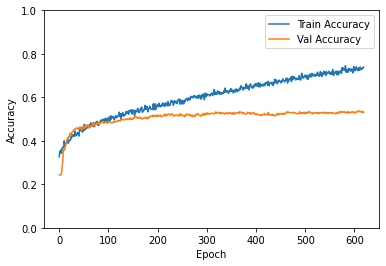

In [17]:
if __name__ == "__main__":
  %tensorflow_version 1
  import subprocess

  subprocess.check_output("pip install pydub", shell=True)
  subprocess.check_output("pip install openl3" , shell=True)

  from tensorflow.keras.models import load_model
  from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_audio
  import glob
  import time
  import importlib
  from sklearn.preprocessing import Normalizer
  from subprocess import Popen, PIPE, STDOUT
  import os
  import pickle
  import openl3
  import soundfile as sf
  import importlib
  import numpy as np
  import pandas as pd
  from matplotlib import pyplot as plt


  from pydub import AudioSegment
  import audioread
  import time
  import numpy as np
  import subprocess
  from tensorflow import keras
  from tensorflow.keras.callbacks import EarlyStopping
  from tensorflow.keras.callbacks import ModelCheckpoint
  from matplotlib import pyplot
  import tensorflow as tf
  from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional


  from google.colab import drive
  drive.mount('/content/gdrive' , force_remount=True)


  model_test = audio_model()

  #Train the model

  #MAKE SURE TO CHANGE THE SAVE PATH

  X_train , Y_train , X_val , Y_val = exampleDataLoad()

  X_train_norm , X_val_norm = Normalize(X_train, X_val)



  Model_path = "" # enter your model path here

  Model_path = "/content/gdrive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-new/models/OPENL3_audio_api_train_test-1-500-epochs-0.5_hop--BEST_MODEL-w-VAL--1e-6-lr-0.2-dropout-512-feat-map-batch-norm-3-cnn-layers.h5"
  model, history = model_test.train(X_train_norm, Y_train , X_val=X_val_norm , Y_val=Y_val ,  save_path=Model_path )

  plot_history(history)
